In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

## Data processing

### Read data

In [36]:
df = pd.read_csv("all_coins_data.csv")
df = df[["time","daily_log_return", "coin"]]
df.head()


,time,daily_log_return,coin
0,2020-08-22,0.019340,ADA
1,2020-08-23,-0.030797,ADA
2,2020-08-24,0.017945,ADA
3,2020-08-25,-0.094018,ADA
4,2020-08-26,0.015859,ADA


In [37]:
df_pivoted = df.pivot(index="coin", columns="time", values="daily_log_return")
df_pivoted.head()

time,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31,...,2021-04-15,2021-04-16,2021-04-17,2021-04-18,2021-04-19,2021-04-20,2021-04-21,2021-04-22,2021-04-23,2021-04-24
coin,,,,,,,,,,,,,,,,,,,,,
ADA,0.019340,-0.030797,0.017945,-0.094018,0.015859,-0.064072,0.021209,0.061912,0.008540,0.041638,...,0.018412,-0.047035,-0.028009,-0.070920,-0.067096,0.059247,-0.052580,-0.050245,0.012153,-0.027111
ALGO,0.061710,0.083686,0.025879,-0.114357,-0.021398,-0.053381,0.023308,0.000562,-0.030216,-0.031357,...,0.071176,-0.041564,0.118078,-0.149741,-0.120610,0.000000,-0.065414,-0.038660,0.000857,-0.035734
ATOM,0.136226,0.283939,-0.039202,0.022299,-0.083755,-0.056663,0.037690,-0.039612,0.048555,-0.058083,...,0.027688,-0.086652,-0.044879,-0.128392,-0.107122,0.099639,-0.082158,-0.044290,0.090114,-0.045315
BCH,0.013840,-0.007142,0.021790,-0.052907,-0.003777,-0.037703,0.015743,-0.002197,0.040682,-0.020645,...,0.061542,0.243818,-0.109446,-0.016340,-0.089443,0.054295,-0.033778,-0.063267,-0.016707,-0.027415
BNB,0.007227,-0.016792,0.034191,-0.054534,0.037135,0.040138,-0.001731,-0.005211,0.028751,-0.020945,...,-0.012386,-0.063653,0.012574,-0.067041,0.045586,0.154173,-0.079246,-0.073323,0.042354,-0.026840


### Normalize Series

In [38]:
# convert dataframe to time_series_dataset
X = to_time_series_dataset(df_pivoted.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)


### Clustering

In [39]:
algo = "DTW_kmeans"
metric = "dtw"

wcss = []

for i in range(1,10):
    model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
    model.fit_predict(X_train)
    wcss.append(model.inertia_)

plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.xlabel('number of clusters')
plt.ylabel('WCSSS');

### Knee calculation

In [ ]:
len(wcss)

9

In [ ]:
from kneed import KneeLocator
kneedle = KneeLocator(x = range(1, 10), y = wcss, curve="concave", direction="decreasing", online = True)
print(kneedle.knee)

5


### Clustering selection

In [ ]:
algo = "DTW_kmeans"
metric = "dtw"

# cluster configuration
N_CLUSTERS = 5

model= TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)

y_pred = model.fit_predict(X_train)


In [ ]:
y_pred

array([0, 3, 3, 0, 0, 0, 1, 4, 0, 2, 1, 0, 3, 0, 0, 1, 1, 2, 4, 2, 0, 3,
       1, 0, 0, 0, 0, 0, 0, 3, 3, 0, 1, 1, 4, 4, 0, 1, 0, 2, 0, 0, 0, 1,
       0])

FileNotFoundError: [Errno 2] No such file or directory: './tsl/plots/DTW_kmeans_cls_lbl_0.png'

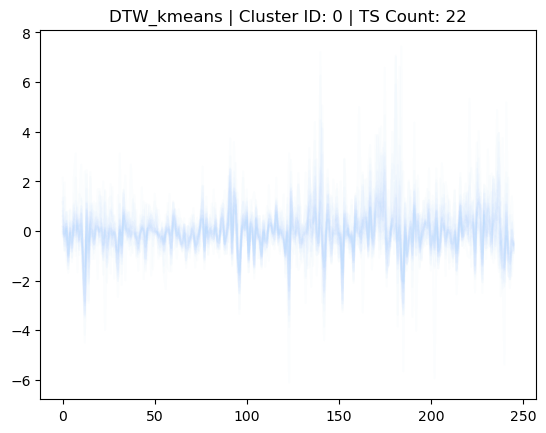

In [ ]:
for yi in range(N_CLUSTERS):
    X_sub = X_train[y_pred == yi]
    ts_cnt = pd.Series(y_pred[y_pred == yi]).shape[0]
    fig = plt.figure()
    plt.title(f"{algo} | Cluster ID: {yi} | TS Count: {ts_cnt}")
    for xx in X_sub:
        plt.plot(xx.ravel(), color='xkcd:sky blue', alpha=0.025)
    fig.savefig(f"./tsl/plots/{algo}_cls_lbl_{yi}.png", dpi=150)
    plt.show()
    plt.close()